In [1]:
import numpy as np
import random
import datetime
import h5py
import os

from progressbar import ProgressBar

import matplotlib as mpl 
mpl.use('Agg')
import matplotlib.pyplot as plt 
from matplotlib import rcParams
%matplotlib inline

In [2]:
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

In [3]:
def mak_all_panels_new(fname1,fname2,fname3,cumval=0,prob=True,
                       density=False,legloc=0,
                       jigger=False):
    with h5py.File(fname1,'r') as f:
        Mconds=(f['Mconds']).value
        rngs=(f['rngs']).value
        Nprim0s_matrix=(f['Nprim0s']).value
        #print Nprim0s
        dat=[]
        for Mcond in Mconds:
            Mcond_dat=[]
            for rng in rngs:
                key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_0scat'\
                    .format(Mcond,rng[0],rng[1])
                Ns0=(f[key]).value
                key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_scat'\
                    .format(Mcond,rng[0],rng[1])
                Ns=(f[key]).value
                Mcond_dat.append([Ns0,Ns])
                #print Mcond_dat
            dat.append(Mcond_dat)
    
    #print dat
    NMconds=len(Mconds)
    Nrngs=rngs.shape[0]
    
    w=13
    h=4.*NMconds
    fig,axs=plt.subplots(NMconds,Nrngs,figsize=(w,h),sharex=True,sharey='row')
    fig.subplots_adjust(wspace=0.,hspace=0.)
    try:
        axs=axs.ravel()
    except AttributeError:
        pass

    axc=0
    axr=0
    axi=-1
    pbar=ProgressBar()
    #for Mcond in pbar(Mconds):
    for Mcond in Mconds:
        Nprim0s=Nprim0s_matrix[axr]
        axr+=1
        for rng in rngs:
            axc+=1
            axi+=1
            #print'Generating panel %i'%axi
            lo=rng[0]
            hi=rng[1]
            Ns_0scat=dat[axr-1][axc-1][0]
            Ns_scat=dat[axr-1][axc-1][1]
            
            #Make the histagram for the data with no scatter
            Nhist_0scat=mak_gal_hgram(axs[axi],Ns_0scat,(144./255., 185./255., 249./255.),'None',0,
                                      cumval=cumval,
                          Nprim0=Nprim0s[0],
                          density=density)[0]
            #Make the histogram for the data with scatter
            Nhist_scat=mak_gal_hgram(axs[axi],Ns_scat,
                                     'None','(57./255., 229./255., 74./255.)',
                                     0.2,histtype='step',cumval=cumval,
                          Nprim0=Nprim0s[1],
                          density=density)[0]
            
            axs[axi].set_yscale('log')
            #Nlo=np.min(np.min(Ns_0scat),np.min(Ns_scat))
            #Nhi=np.max(np.max(Ns_0scat),np.max(Ns_scat))
            #Nhi=1
            #axs[axi].set_ylim(Nlo-0.1,Nhi)
            if axc==1:
                shareyi=axi
                if density:
                    axs[axi].set_ylabel('$n_{\mathregular{gal,\ main\ prog.}}$'
                                        '[Mpc$^{-3}$]',fontsize=18)
                elif prob:
                    if cumval==1:
                        axs[axi].set_ylabel('$P(\leq$count)',fontsize=18)
                    elif cumval==0:
                        axs[axi].set_ylabel('$P$(count)',fontsize=18)
                    elif cumval==-1:
                        axs[axi].set_ylabel('$P(\geq$count)',fontsize=18)
                else:
                    axs[axi].set_ylabel('$N_{\mathregular{gal,\ main\ prog.}}$',
                                        fontsize=18)
                #print np.log10(np.array(axs[axi].get_ylim()))
                '''
                ylim=axs[axi].get_ylim()
                logylo=np.log10(ylim[0])
                logyhi=np.log10(ylim[1])
                #print'difference: %0.2f'%(logylo-logyhi)
                #(logylo-logyhi)/2.
                midy=10**((logylo+logyhi)/2.)
                #print'midy: %f'%np.log10(midy)
                axs[axi].text(-4.5,midy,'$M_{{\star 0}}=10^{{{0:0.1f}}}$' \
                         ' M$_\odot$'.format(Mcond),
                         fontsize=20,rotation='vertical',
                         verticalalignment='center')
                '''
            else:
                plt.setp(axs[axi].get_yticklabels(), visible=False)
                plt.setp(axs[axi].get_yminorticklabels(),visible=False)
                #axs[axi].set_ylim(axs[shareyi].get_ylim())
            #axs[axi].set_xlim(axs[0].get_xlim())          
            axs[axi].set_xticks(np.arange(Ns_scat.max()+2))
            if axr==1:
                if axc==1:
                    axs[axi].set_title('Micro mergers')
                elif axc==2:
                    axs[axi].set_title('Minor mergers')
                elif axc==3:
                    axs[axi].set_title('Major mergers')
                else:
                    raise ValueError('Title error')
            if axr!=NMconds:
                plt.setp(axs[axi].get_xticklabels(), visible=False)
            elif axc==2:
                    axs[axi].set_xlabel('Merger count')
            if axc==Nrngs:
                
                if axr==1:
                    axs[axi].legend(fontsize=15,loc=legloc,framealpha=0.9)
                ylim=axs[axi].get_ylim()
                logylo=np.log10(ylim[0])
                logyhi=np.log10(ylim[1])
                #print'difference: %0.2f'%(logylo-logyhi)
                #(logylo-logyhi)/2.
                midy=10**((logylo+logyhi)/2.)
                #print'midy: %f'%np.log10(midy)
                axs[axi].text(-5.*4.,midy,'$M_{{\star 0}}=10^{{{0:0.1f}}}$' \
                         ' M$_\odot$'.format(Mcond),
                         fontsize=20,rotation='vertical',
                         verticalalignment='center')
                if jigger:
                    if cumval in [-1,1]:
                        ylim=axs[axi].get_ylim()

                        print'\noriginal limits:'
                        print np.log10(np.array(ylim))
                        datmin=min(np.min(Nhist_0scat[Nhist_0scat>0]),
                                   np.min(Nhist_scat[Nhist_scat>0]))
                        print'min: %f'%np.log10(datmin)

                        #print type(Nhist_0scat)


                        #if ylim[0]>datmin:
                        #    axs[axi].set_ylim(datmin,ylim[1])
                        print np.log10(10**(np.log10(ylim[1])+0.02))
                        newlim=np.array([10**(np.log10(datmin)-1),
                                        ylim[1]])
                        print'new lim:'
                        print np.log10(newlim)
                        axs[axi].set_ylim(newlim)
                                          #10**np.log10(ylim[1]+0.02))
                        #print'new limits:'
                        #print np.log10(np.array(axs[axi].get_ylim()))
                        #print np.log10(Nhist_0scat)
                        #print np.log10(Nhist_scat)
                axc=0
    fnames=[fname2,fname3]
    fi=0.
    for fname in fnames:
        fi+=1.
        with h5py.File(fname,'r') as f:
            Mconds=(f['Mconds']).value
            rngs=(f['rngs']).value
            Nprim0s_matrix=(f['Nprim0s']).value
            #print Nprim0s
            dat=[]
            for Mcond in Mconds:
                Mcond_dat=[]
                for rng in rngs:
                    key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_0scat'\
                        .format(Mcond,rng[0],rng[1])
                    Ns0=(f[key]).value
                    key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_scat'\
                        .format(Mcond,rng[0],rng[1])
                    Ns=(f[key]).value
                    Mcond_dat.append([Ns0,Ns])
                    #print Mcond_dat
                dat.append(Mcond_dat)
        
        axc=0
        axr=0
        axi=-1
        pbar=ProgressBar()
        #for Mcond in pbar(Mconds):
        for Mcond in Mconds:
            Nprim0s=Nprim0s_matrix[axr]
            axr+=1
            for rng in rngs:
                axc+=1
                axi+=1
                #print'Generating panel %i'%axi
                lo=rng[0]
                hi=rng[1]
                Ns_0scat=dat[axr-1][axc-1][0]
                Ns_scat=dat[axr-1][axc-1][1]

                #Make the histogram for the data with scatter
                Nhist_scat=mak_gal_hgram(axs[axi],Ns_scat,
                                         'None',((57.+20.*fi)/255., 229./255., 74./255.),
                                         0.2,histtype='step',cumval=cumval,
                              Nprim0=Nprim0s[1],
                              density=density)[0]        
    plt.show()
    return

In [4]:
#tstmp=20190212
#tstmp=20190122

def mak_all_panels(fname,cumval=0,prob=True,density=False,legloc=0,
                   jigger=False):
    with h5py.File(fname,'r') as f:
        Mconds=(f['Mconds']).value
        rngs=(f['rngs']).value
        Nprim0s_matrix=(f['Nprim0s']).value
        #print Nprim0s
        dat=[]
        for Mcond in Mconds:
            Mcond_dat=[]
            for rng in rngs:
                key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_0scat'\
                    .format(Mcond,rng[0],rng[1])
                Ns0=(f[key]).value
                key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_scat'\
                    .format(Mcond,rng[0],rng[1])
                Ns=(f[key]).value
                Mcond_dat.append([Ns0,Ns])
                #print Mcond_dat
            dat.append(Mcond_dat)
    
    #print dat
    NMconds=len(Mconds)
    Nrngs=rngs.shape[0]
    
    w=13
    h=4.*NMconds
    fig,axs=plt.subplots(NMconds,Nrngs,figsize=(w,h),sharex=True,sharey='row')
    fig.subplots_adjust(wspace=0.,hspace=0.)
    try:
        axs=axs.ravel()
    except AttributeError:
        pass

    axc=0
    axr=0
    axi=-1
    pbar=ProgressBar()
    #for Mcond in pbar(Mconds):
    for Mcond in Mconds:
        Nprim0s=Nprim0s_matrix[axr]
        axr+=1
        for rng in rngs:
            axc+=1
            axi+=1
            #print'Generating panel %i'%axi
            lo=rng[0]
            hi=rng[1]
            Ns_0scat=dat[axr-1][axc-1][0]
            Ns_scat=dat[axr-1][axc-1][1]
            
            #Make the histagram for the data with no scatter
            Nhist_0scat=mak_gal_hgram(axs[axi],Ns_0scat,(144./255., 185./255., 249./255.),'None',0,
                                      cumval=cumval,
                          Nprim0=Nprim0s[0],
                          density=density)[0]
            
            #Make the histogram for the data with scatter
            Nhist_scat=mak_gal_hgram(axs[axi],Ns_scat,
                                     'None','r',
                                     0.2,histtype='step',cumval=cumval,
                          Nprim0=Nprim0s[1],
                          density=density)[0]

            
            axs[axi].set_yscale('log')
            #Nlo=np.min(np.min(Ns_0scat),np.min(Ns_scat))
            #Nhi=np.max(np.max(Ns_0scat),np.max(Ns_scat))
            #Nhi=1
            #axs[axi].set_ylim(Nlo-0.1,Nhi)
            if axc==1:
                shareyi=axi
                if density:
                    axs[axi].set_ylabel('$n_{\mathregular{gal,\ main\ prog.}}$'
                                        '[Mpc$^{-3}$]',fontsize=18)
                elif prob:
                    if cumval==1:
                        axs[axi].set_ylabel('$P(\leq$count)',fontsize=18)
                    elif cumval==0:
                        axs[axi].set_ylabel('$P$(count)',fontsize=18)
                    elif cumval==-1:
                        axs[axi].set_ylabel('$P(\geq$count)',fontsize=18)
                else:
                    axs[axi].set_ylabel('$N_{\mathregular{gal,\ main\ prog.}}$',
                                        fontsize=18)
                #print np.log10(np.array(axs[axi].get_ylim()))
                '''
                ylim=axs[axi].get_ylim()
                logylo=np.log10(ylim[0])
                logyhi=np.log10(ylim[1])
                #print'difference: %0.2f'%(logylo-logyhi)
                #(logylo-logyhi)/2.
                midy=10**((logylo+logyhi)/2.)
                #print'midy: %f'%np.log10(midy)
                axs[axi].text(-4.5,midy,'$M_{{\star 0}}=10^{{{0:0.1f}}}$' \
                         ' M$_\odot$'.format(Mcond),
                         fontsize=20,rotation='vertical',
                         verticalalignment='center')
                '''
            else:
                plt.setp(axs[axi].get_yticklabels(), visible=False)
                plt.setp(axs[axi].get_yminorticklabels(),visible=False)
                #axs[axi].set_ylim(axs[shareyi].get_ylim())
            #axs[axi].set_xlim(axs[0].get_xlim())          
            axs[axi].set_xticks(np.arange(Ns_scat.max()+2))
            if axr==1:
                if axc==1:
                    axs[axi].set_title('Micro mergers')
                elif axc==2:
                    axs[axi].set_title('Minor mergers')
                elif axc==3:
                    axs[axi].set_title('Major mergers')
                else:
                    raise ValueError('Title error')
            if axr!=NMconds:
                plt.setp(axs[axi].get_xticklabels(), visible=False)
            elif axc==2:
                    axs[axi].set_xlabel('Merger count')
            if axc==Nrngs:
                
                if axr==1:
                    axs[axi].legend(fontsize=15,loc=legloc,framealpha=0.9)
                ylim=axs[axi].get_ylim()
                logylo=np.log10(ylim[0])
                logyhi=np.log10(ylim[1])
                #print'difference: %0.2f'%(logylo-logyhi)
                #(logylo-logyhi)/2.
                midy=10**((logylo+logyhi)/2.)
                #print'midy: %f'%np.log10(midy)
                axs[axi].text(-5.*4.,midy,'$M_{{\star 0}}=10^{{{0:0.1f}}}$' \
                         ' M$_\odot$'.format(Mcond),
                         fontsize=20,rotation='vertical',
                         verticalalignment='center')
                if jigger:
                    if cumval in [-1,1]:
                        ylim=axs[axi].get_ylim()

                        print'\noriginal limits:'
                        print np.log10(np.array(ylim))
                        datmin=min(np.min(Nhist_0scat[Nhist_0scat>0]),
                                   np.min(Nhist_scat[Nhist_scat>0]))
                        print'min: %f'%np.log10(datmin)

                        #print type(Nhist_0scat)


                        #if ylim[0]>datmin:
                        #    axs[axi].set_ylim(datmin,ylim[1])
                        print np.log10(10**(np.log10(ylim[1])+0.02))
                        newlim=np.array([10**(np.log10(datmin)-1),
                                        ylim[1]])
                        print'new lim:'
                        print np.log10(newlim)
                        axs[axi].set_ylim(newlim)
                                          #10**np.log10(ylim[1]+0.02))
                        #print'new limits:'
                        #print np.log10(np.array(axs[axi].get_ylim()))
                        #print np.log10(Nhist_0scat)
                        #print np.log10(Nhist_scat)
                axc=0
    plt.show()
    return

def comp_gal_hgram(ax,Mcond0,mMlo,mMhi,condtype,scat):
    read0scat=readfile(Mcond0,condtype,0.)
    readscat=readfile(Mcond0,condtype,scat)
    Ns_0scat=gal_hgram_dat(mMlo,mMhi,read0scat[0],read0scat[3],read0scat[4])
    Ns_scat=gal_hgram_dat(mMlo,mMhi,readscat[0],readscat[3],readscat[4])
    
    mak_gal_hgram(ax,Ns_0scat,'b',0.)
    mak_gal_hgram(ax,Ns_scat,'g',scat)
    
    return
    
def mak_gal_hgram(ax,Ns,fc,ec,scat,cumval=0,Nprim0=None,density=False,histtype='bar'):
    if (Nprim0 is not None) & (density is not False):
        raise ValueError('Either specify Nprim0 for a probability density plot or'
                         'specify density=True for a volumetric density plot.')
    lo=min(Ns)
    hi=max(Ns)
    #bins=np.arange(lo-0.5,hi+1.5)
    bins=np.arange(-0.5,7.5)
    midbins=(bins[1:]+bins[:-1])/2.
    #print midbins
    #print bins
    if density:
        Ns_hist=ax.hist(Ns,bins,fc=fc,ec=ec,lw=3,cumulative=cumval,histtype=hissttype,
                alpha=1,rwidth=1.,
                label='{0:0.1f} dex scatter'.format(scat),
                weights=np.repeat(1./(250./0.7)**3.,len(Ns)))[0]
    elif Nprim0:
        #print Nprim0
        Ns_hist=ax.hist(Ns,bins,fc=fc,ec=ec,lw=3,cumulative=cumval,histtype=histtype,
                alpha=1,rwidth=1.,
                label='{0:0.1f} dex scatter'.format(scat),
                weights=np.repeat(1./Nprim0,len(Ns)))[0]
    else:
        Ns_hist=ax.hist(Ns,bins,fc=fc,ec=ec,lw=3,cumulative=cumval,histtype=histtype,
                alpha=1,rwidth=1.,
                label='{0:0.1f} dex scatter'.format(scat))[0]
    return Ns_hist,midbins
    
def gal_hgram_dat(mMlo,mMhi,mMs,iprim0s_merg,iprim0s_keys):
    #This currently doesn't get used 2019 02 13
    inrange=(mMs>mMlo)&(mMs<mMhi)
    #pbar=ProgressBar()
    #print'Generating main progenitor mask.'
    #ismp_matrix=np.array([iprim0s_merg==key for key in pbar(iprim0s_keys)])
    #ismp_matrix=np.array([iprim0s_merg==key for key in iprim0s_keys])
    print'Generating Ns'
    pbar=ProgressBar()
    Ns=[]
    '''
    for key in pbar(iprim0s_keys):
        
        Ns+=[np.sum(ismp&inrange) for ismp in [iprim0s_merg==key]]
    Ns=np.array(Ns)
    '''
    #'''
    Ns=np.array(np.sum(ismp&inrange 
                       for ismp in 
                       (iprim0s_merg==key for key in pbar(iprim0s_keys))
                      ))
    return Ns

###############################################################################

def readfile(Mcond0,condtype,scat,tstmp,seed=1,app=''):
    #fname='/home/users/staudt/projects/mergers/dat/' \
    #      'gal_mM0_M{3}0_{0}_scat{2:0.2f}_{1}.h5'.format(Mcond0,tstmp,scat,condtype)
    #print tstmp
    #print condtype
    if seed:
        seedstr='_'+str(seed)+'seed'
    else:
        seedstr=''
    fname='/home/users/staudt/projects/mergers/dat/' \
          'gal_mM0_M{3}0_{0:0.2f}_scat{2:0.2f}{4}_{1}{5}.h5'\
          .format(Mcond0,tstmp,scat,condtype,seedstr,app)
    #print fname
    with h5py.File(fname,'r') as f:
        mMs=np.array(f['mMs'])
        ms=np.array(f['ms'])
        Ms=np.array(f['Ms'])
        iprim0s_merg=np.array(f['iprim0s_merg'])
        iprim0s_keys=np.array(f['iprim0s_keys'])
        Nprim0=(f['Nprim0']).value
        zbeg=(f['zbeg']).value
        zend=(f['zend']).value
    return mMs,ms,Ms,iprim0s_merg,iprim0s_keys,Nprim0,zbeg,zend

###############################################################################

def count(mM0s,lo,hi,cumval=-1):
    bins=np.linspace(lo,hi,100)
    print bins
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)
    Ns,bins=ax.hist(mM0s,bins=bins,cumulative=cumval,ec='k')[:2]
    midbins=(bins[:-1]+bins[1:])/2.
    plt.clf()
    #print Ns
    #print midbins
    return Ns,midbins

def makhist(ax,mM0s,lo,hi,scat,color,cumval=-1):
    bins=np.linspace(lo,hi,100)
    label='{0:0.1f} dex scatter'.format(scat)
    ax.hist(mM0s,bins=bins,cumulative=cumval,label=label,alpha=0.5,color=color)
    return

def comp(Mcond0,lo,hi,tstmp,scat=0.2,cumval=-1,condtype='cengal',
         tstmp0=None,seed=1,app=''):
    if tstmp0 is None:
        tstmp0=tstmp
    #print condtype
    #print seed
    mM0s_0scat=readfile(Mcond0,condtype,0,tstmp0,seed=None)[0]
    mM0s_scat=readfile(Mcond0,condtype,scat,tstmp,seed=seed,app=app)[0]
    
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)
    makhist(ax,mM0s_0scat,lo,hi,0,'b',cumval=cumval)
    makhist(ax,mM0s_scat,lo,hi,scat,'g',cumval=cumval)
    
    ax.set_title('$M_\mathrm{{hal,0}}=10^{{{0}}}$ galaxy merger rates'.format(Mcond0))
    ax.set_ylabel('$N(m_{\star z}/M_{\star 0})$')
    ax.set_xlabel('log($m_{\star z}/M_{\star 0}$)')
    ax.legend()
    plt.show()
    return

def compall(Mcond0,condtype,tstmp,tstmp0=None,scat=0.2,cumval=-1,seed=1,
            app=''):
    if tstmp0 is None:
        tstmp0=tstmp
    #tiny
    lo=-5
    hi=-1
    comp(Mcond0,lo,hi,tstmp,scat,cumval,condtype,tstmp0,seed,app)
    
    #minor
    lo=-1
    hi=-0.5
    comp(Mcond0,lo,hi,tstmp,scat,cumval,condtype,tstmp0,seed,app)
    
    #major
    lo=-0.5
    hi=0.5
    comp(Mcond0,lo,hi,tstmp,scat,cumval,condtype,tstmp0,seed,app)
    
    return

In [5]:
def quench_dat(fname):
    with h5py.File(fname,'r') as f:
        Mconds=(f['Mconds']).value
        rngs=(f['rngs']).value
        Nprim0s_matrix=(f['Nprim0s']).value
        #print Nprim0s
        dat=[]
        for Mcond in Mconds:
            Mcond_dat=[]
            for rng in rngs:
                key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_0scat'\
                    .format(Mcond,rng[0],rng[1])
                Ns0=(f[key]).value
                key='Ns_{0:0.1f}M_{1:0.1f}-{2:0.1f}_scat'\
                    .format(Mcond,rng[0],rng[1])
                Ns=(f[key]).value
                Mcond_dat.append([Ns0,Ns])
                #print Mcond_dat
            dat.append(Mcond_dat)
    
    #print dat[1]
    #print np.where(dat!=0.)
    #print Nprim0s_matrix
    NMconds=len(Mconds)
    Nrngs=rngs.shape[0]
    
    pbar=ProgressBar()
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    ps=np.ones((Nrngs,NMconds))*np.nan
    
    for Mi, Mcond in enumerate(Mconds):
        #Number of primary ending galaxies for the 0scat and scat data:
        Nprim0s=Nprim0s_matrix[Mi]
        for ri,rng in enumerate(rngs):
            Ns_scat=dat[Mi][ri][1]            
            Nhist_scat,midbins=mak_gal_hgram(ax,Ns_scat,
                                      (121./255., 234./255., 137/255.),
                          'None',0.2,cumval=-1,
                          Nprim0=Nprim0s[1])
            #The 1 element of Nhist_scat is p(>count)
            ps[(ri,Mi)]=Nhist_scat[1]
    plt.clf()
    print rngs
    return ps,Mconds        

[[-0.48712125  0.        ]
 [-1.01        0.        ]]
(array([[0.00139005, 0.0024865 , 0.00404289, 0.00468886, 0.00589342,
        0.02246343, 0.15058084, 0.44427002],
       [0.00235316, 0.00568401, 0.0088873 , 0.01512966, 0.04097169,
        0.12783762, 0.32312222, 0.60753532]]), array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5]))


<Figure size 432x288 with 0 Axes>

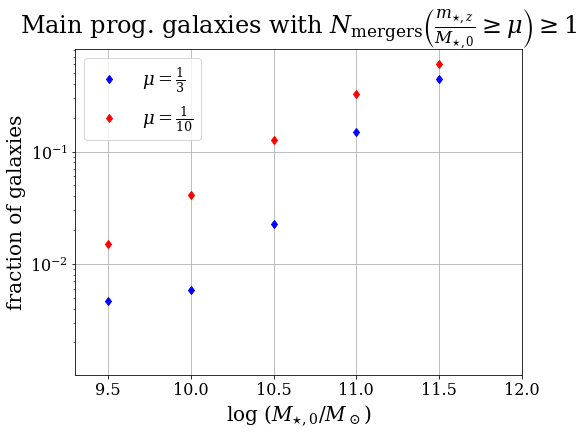

"\nfname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed_20190213_for_quench_eq.h5'\nout=quench_dat(fname)\nprint out\n\nfig=plt.figure(figsize=(8,6))\nax=fig.add_subplot(111)\nax.semilogy(out[1],out[0][0],'bd',label='$\\mu=\\frac{1}{3}$')\nax.semilogy(out[1],out[0][1],'rd',label='$\\mu=\\frac{1}{10}$')\nax.set_title('Main prog. galaxies with $N_\\mathrm{mergers}\\left(\\frac{m_{\\mathrm{\\star},z}}{M_{\\star,0}}\\approx\\mu\\right)\\geq 1$')\nax.set_ylabel('fraction of galaxies')\nax.set_xlabel('log $(M_{\\star,0}/M_\\odot)$')\nax.legend()\nplt.show()\n"

In [32]:
fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed'\
      '_20190213_for_quench_geq.h5'
out=quench_dat(fname)
print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,0}}\geq\mu\\right)\geq 1$')
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.set_xlim(9.3,12.)
ax.legend()
plt.show()

'''
fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed_20190213_for_quench_eq.h5'
out=quench_dat(fname)
print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,0}}\\approx\mu\\right)\geq 1$')
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()
'''
end=1

[[-0.47712125  0.        ]
 [-1.          0.        ]]
(array([[0.00911829, 0.00951159, 0.02588603, 0.156986  , 0.45473574,
        0.57142857],
       [0.02124859, 0.05171499, 0.14706006, 0.3471515 , 0.62166405,
        0.71428571]]), array([ 9.5, 10. , 10.5, 11. , 11.5, 12. ]))


<Figure size 432x288 with 0 Axes>

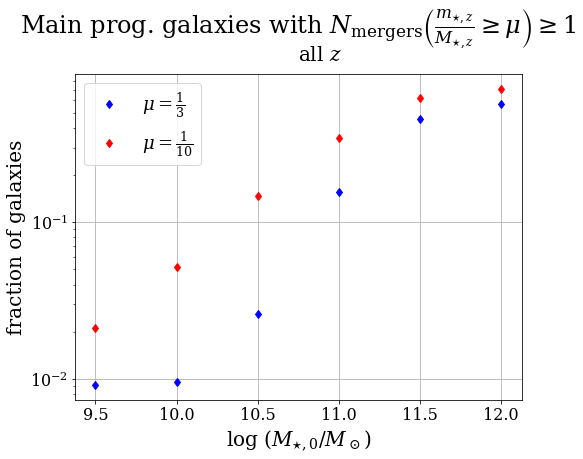

[[-0.47712125  0.        ]
 [-1.          0.        ]]
(array([[0.00911829, 0.00951159, 0.02585809, 0.15694621, 0.45473574,
        0.57142857],
       [0.02124859, 0.05170644, 0.14700418, 0.34703215, 0.62166405,
        0.71428571]]), array([ 9.5, 10. , 10.5, 11. , 11.5, 12. ]))


<Figure size 432x288 with 0 Axes>

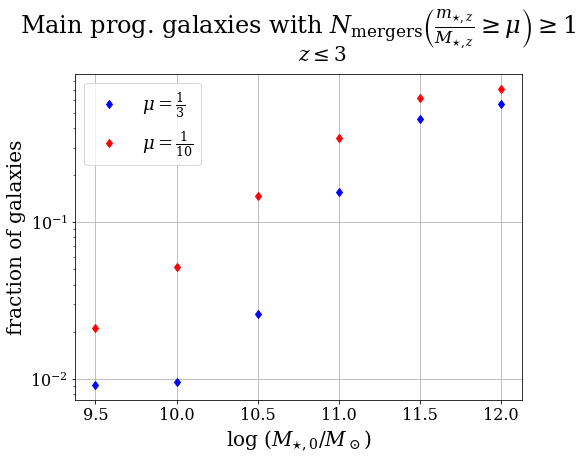

[[-0.47712125  0.        ]
 [-1.          0.        ]]
(array([[0.00911829, 0.00951159, 0.02583016, 0.15670751, 0.45316588,
        0.57142857],
       [0.02124859, 0.05169789, 0.14686448, 0.34575907, 0.61643119,
        0.71428571]]), array([ 9.5, 10. , 10.5, 11. , 11.5, 12. ]))


<Figure size 432x288 with 0 Axes>

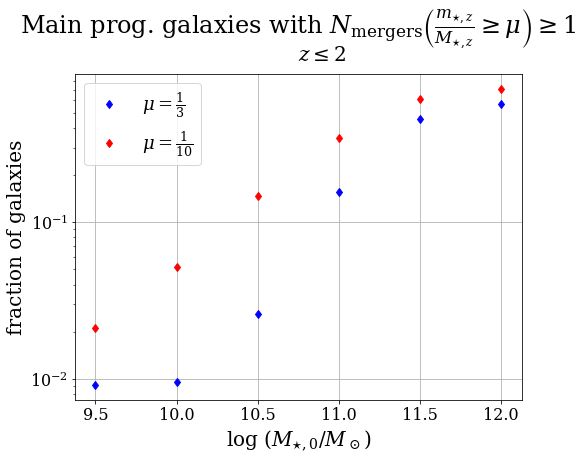

[[-0.47712125  0.        ]
 [-1.          0.        ]]
(array([[0.0089601 , 0.00915234, 0.02495006, 0.14890993, 0.41705913,
        0.42857143],
       [0.02091322, 0.05076555, 0.14094128, 0.31214195, 0.54526426,
        0.42857143]]), array([ 9.5, 10. , 10.5, 11. , 11.5, 12. ]))


<Figure size 432x288 with 0 Axes>

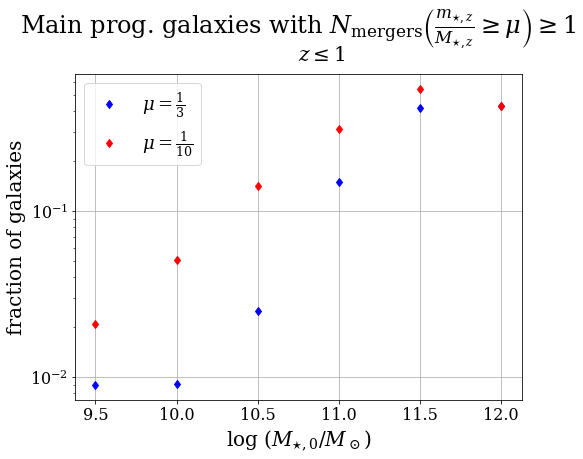

In [29]:
fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed'\
      '_20190220_allz.h5'
out=quench_dat(fname)
print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'all $z$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed_20190220_3zmax.h5'
out=quench_dat(fname)
print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'$z\leq 3$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed_20190220_2zmax.h5'
out=quench_dat(fname)
print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'$z\leq 2$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed_20190220_1zmax.h5'
out=quench_dat(fname)
print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'$z\leq 1$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

[[-0.47712125  0.        ]
 [-1.30103     0.        ]]


<Figure size 432x288 with 0 Axes>

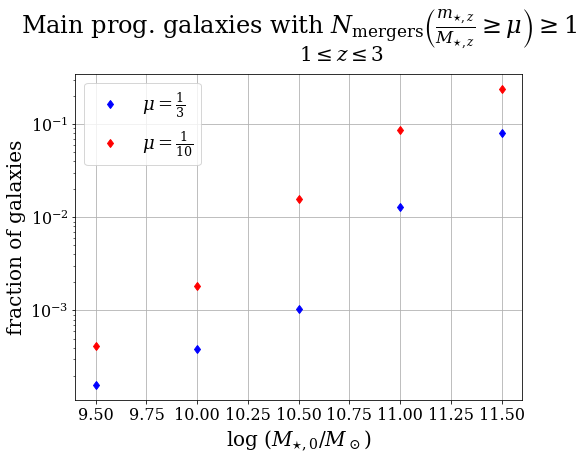

[[-0.47712125  0.        ]
 [-1.          0.        ]]


<Figure size 432x288 with 0 Axes>

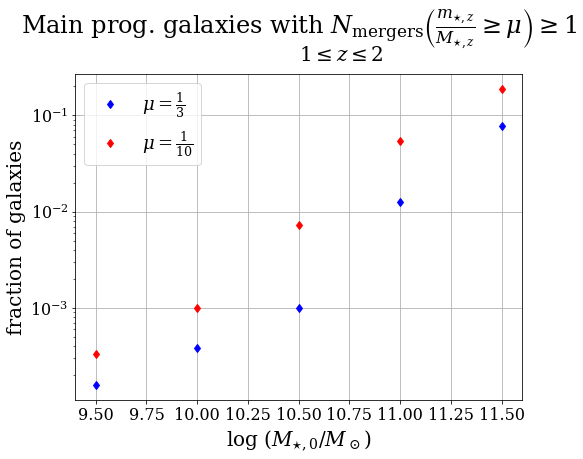

[[-0.47712125  0.        ]
 [-1.          0.        ]]


<Figure size 432x288 with 0 Axes>

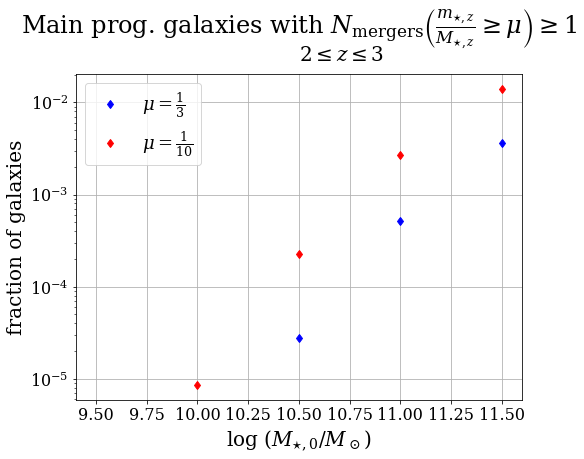

In [31]:
fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed'\
      '_20190301_1<z<3.h5'
out=quench_dat(fname)
#print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}'
             '\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'$1\leq z\leq3$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed'\
      '_20190301_1<z<2.h5'
out=quench_dat(fname)
#print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}'
             '\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'$1\leq z\leq 2$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_1seed'\
      '_20190301_2<z<3.h5'
out=quench_dat(fname)
#print out

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.semilogy(out[1],out[0][0],'bd',label='$\mu=\\frac{1}{3}$')
ax.semilogy(out[1],out[0][1],'rd',label='$\mu=\\frac{1}{10}$')
ax.set_title('Main prog. galaxies with $N_\mathrm{mergers}'
             '\\left(\\frac{m_{\mathrm{\star},z}}{M_{\star,z}}'
             '\geq\mu\\right)\geq 1$',
             pad=40)
ax.text(0.5,1.04,'$2\leq z\leq 3$',fontsize=20,transform=ax.transAxes)
ax.set_ylabel('fraction of galaxies')
ax.set_xlabel('log $(M_{\star,0}/M_\odot)$')
ax.legend()
plt.show()

In [33]:
np.ones((2,7))

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

[[[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])], [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])], [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]], [[array([0, 1, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0])], [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])], [array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 0, 0])]], [[array([1, 0, 0, ..., 0, 1, 0]), array([2, 2, 0, ..., 2, 1, 2])], [array([1, 2, 0, ..., 0, 1, 2]), array([0, 0, 2, ..., 0, 1, 0])], [array([0, 1, 1, ..., 2, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]]]


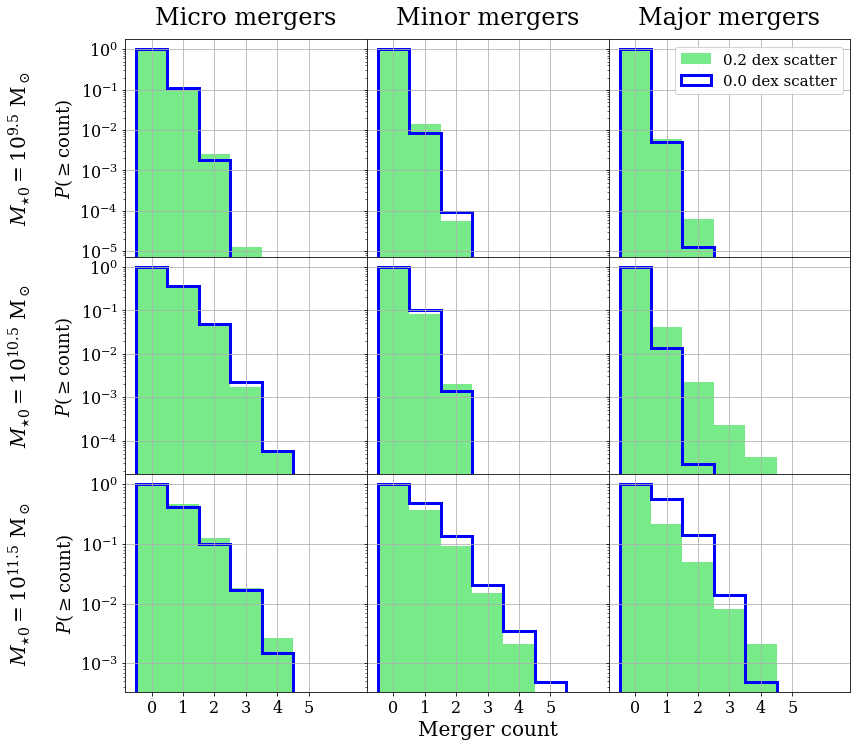

In [132]:
fname='/home/users/staudt/projects/mergers/dat/gal_hgram_dat_20190128.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
#mak_all_panels(fname,cumval=0)

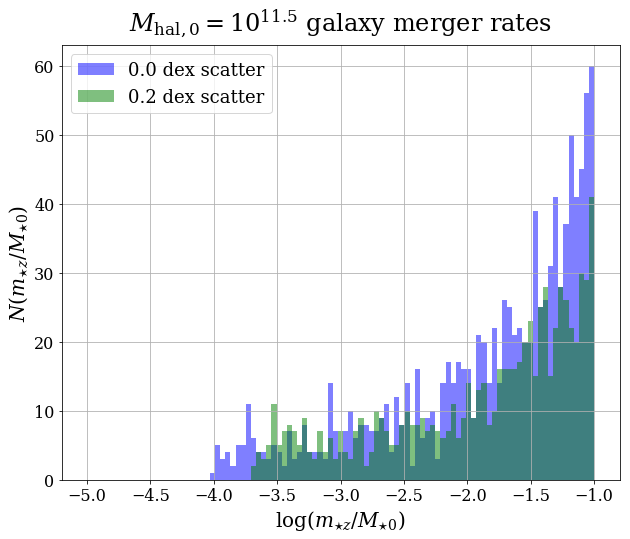

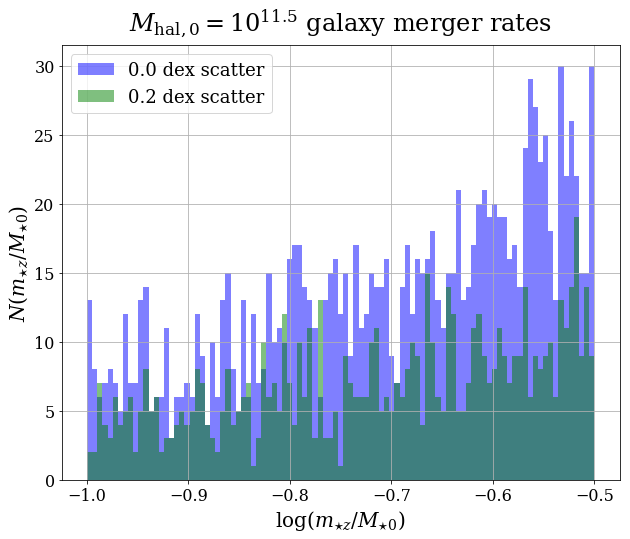

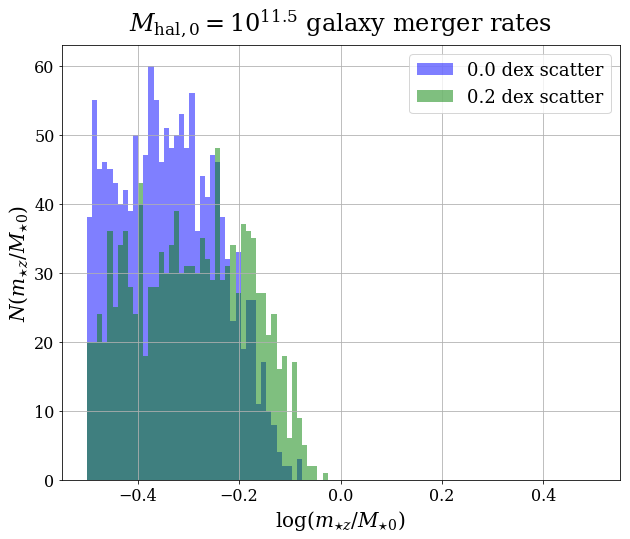

In [101]:
compall(11.5,'cengal',tstmp='20190212',tstmp0='20190212',cumval=0,seed=1,app='')
#compall(10.5,'cengal',tstmp='20190213',tstmp0='20190205',cumval=0,seed=None,app='test')
#compall(10.5,'cengal',tstmp='20190212',tstmp0='20190205',cumval=0)
#compall(11.5,'cengal',tstmp='20190205',tstmp0='20190205',cumval=0)

In [ ]:
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_1seed_20190206.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_2seed_20190206.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_3seed_20190206.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)

IndexError: list index out of range

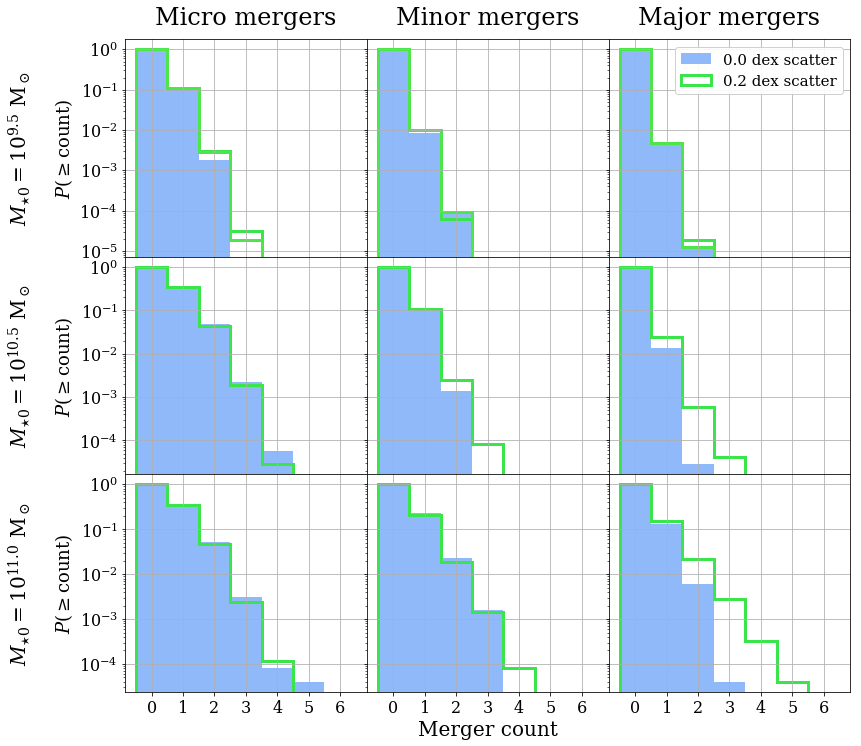

In [26]:
fname1='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_1seed_20190206_with11.h5'
fname2='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_2seed_20190206_with11.h5'
fname3='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_3seed_20190206_with11.h5'
mak_all_panels_new(fname1,fname2,fname3,cumval=-1,legloc=1,jigger=False)
'''

mak_all_panels_new(fname,cumval=-1,legloc=1,jigger=False)

mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
'''

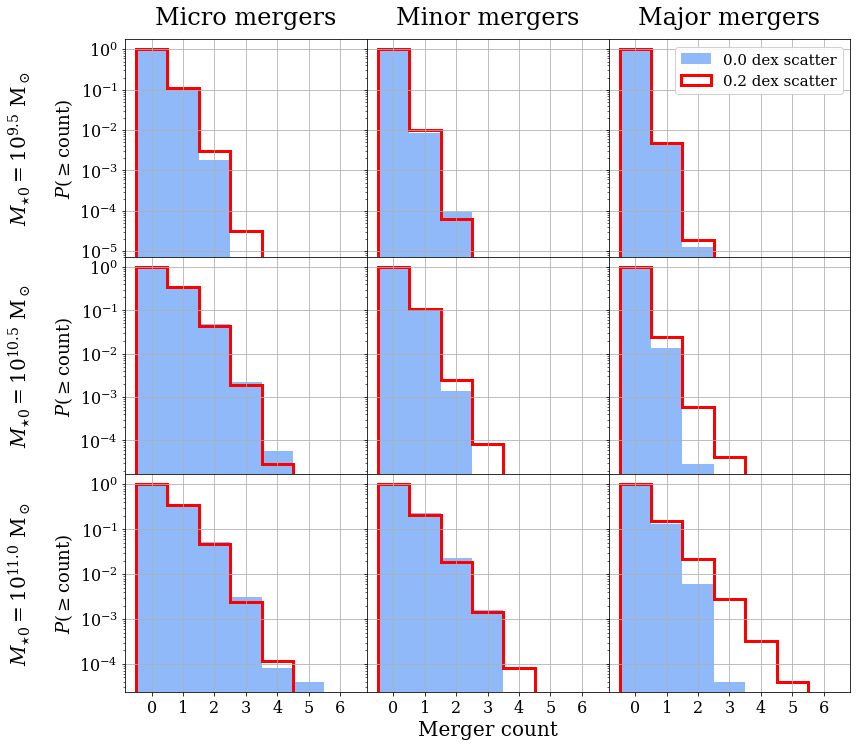

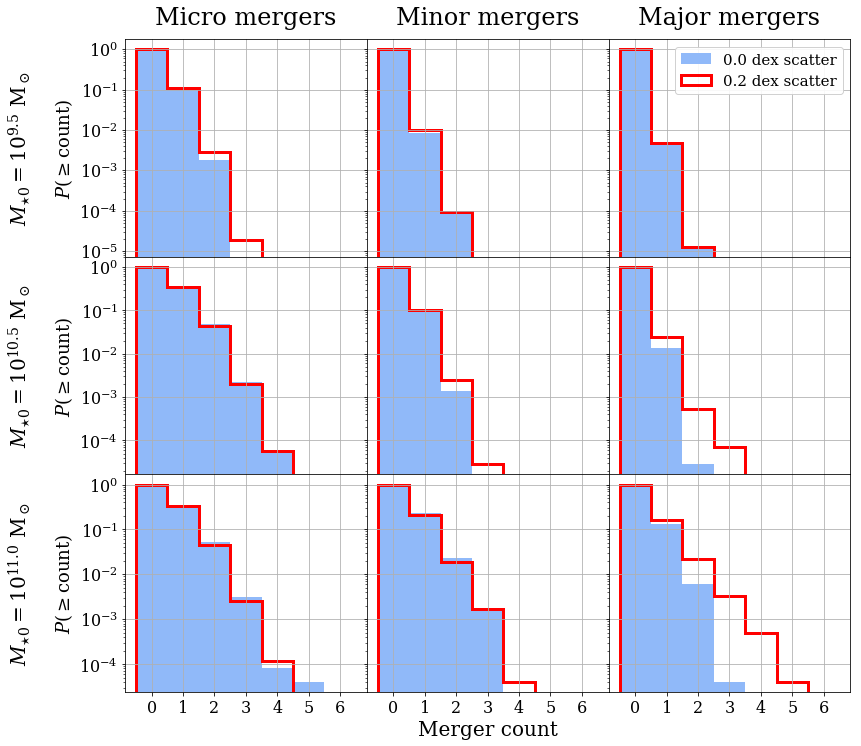

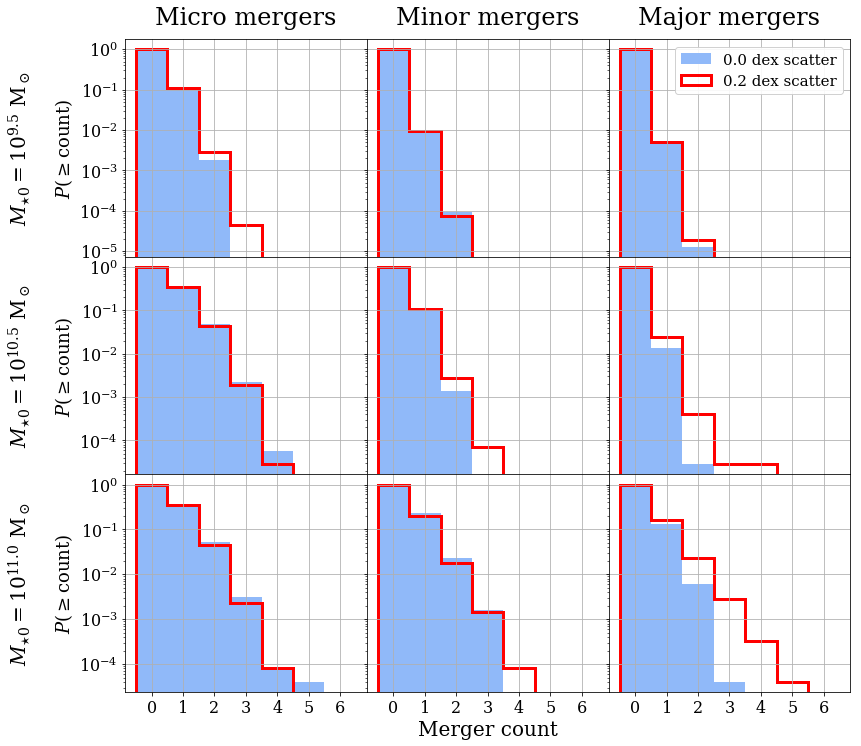

In [33]:
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_1seed_20190206_with11.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_2seed_20190206_with11.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_3seed_20190206_with11.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)


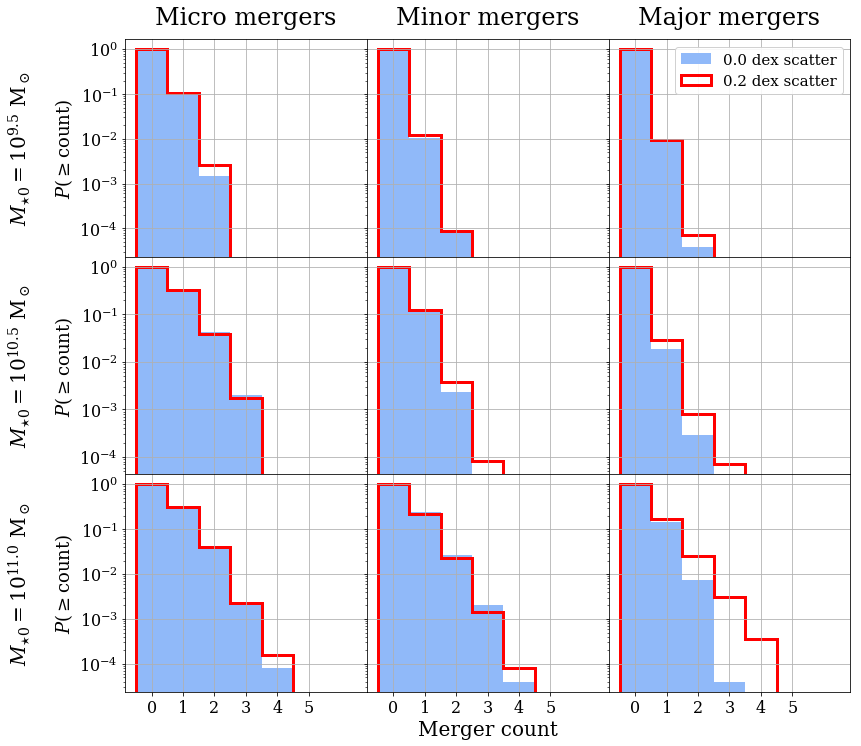

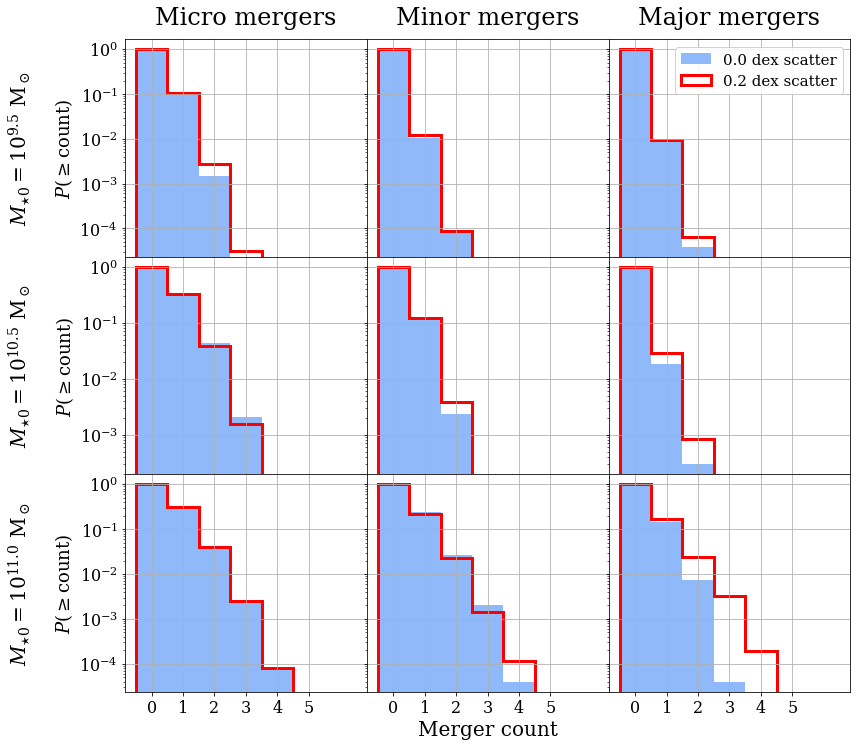

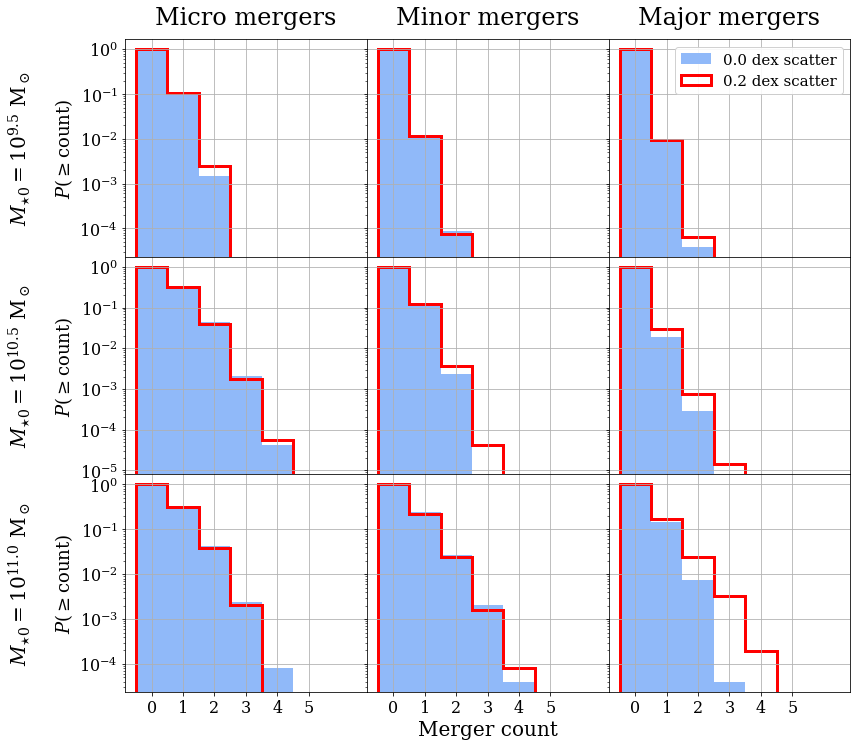

In [35]:
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_100seed_20190211.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_200seed_20190211.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)
fname='/home/users/staudt/projects/mergers/dat/'\
      'gal_hgram_dat_300seed_20190211.h5'
mak_all_panels(fname,cumval=-1,legloc=1,jigger=False)